# 프로젝트: 작사가 만들기

### 목표
1. 가사 데이터를 정제과정을 거쳐 전처리를 한다.
2. 모델 생성 후 평가하고, 그 결과를 분석해 더 나은 성능을 가진 모델을 만든다.
3. 학습된 모델로 가사를 써본다.

## 데이터 불러오기

In [76]:
import os
import glob
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus= []
for txt_file in txt_list:
    with open(txt_file, 'r') as f:
        raw_corpus += f.read().splitlines()

print(f'데이터 개수: {len(raw_corpus)}')
print(f'데이터 샘플:\n {raw_corpus[:3]}')

데이터 개수: 187088
데이터 샘플:
 ['I hear you callin\', "Here I come baby"', 'To save you, oh oh', "Baby no more stallin'"]


In [77]:
print(*raw_corpus[-1:-200])

In [78]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue
    if idx > 300: break 
    print(sentence)

I hear you callin', "Here I come baby"
To save you, oh oh
Baby no more stallin'
These hands have been longing to touch you baby
And now that you've come around, to seein' it my way
You won't regret it baby, and you surely won't forget it baby
It's unbelieveable how your body's calling for me
I can just hear it callin' callin' for me My body's callin' for you
My body's callin' for you
My body's callin' for you
My body's callin' for you Tell me, what's your desire
Baby your wish is my deal oh yes it is baby
Let me take you higher
Show you how you should feel, baby
Oh So we speak now and forever hold your body
Whatever it is you want from me, baby
You see you don't have to say nothing
Knowing your body wants something
And it's easy for me to see
That your body's callin' for me My body's callin' for you
My body's callin' for you
My body's callin' for you
My body's callin' for you I'm listening baby
I hear you callin' me
I'm listening baby
I hear you callin' me
I'm listening baby
I hear you

## 데이터 정제

1. 대문자를 소문자로 바꾼다.
2. 문장부호(? ! . , ) 양쪽에 공백을 넣는다. 
    - [']의 경우 what's나 I'm 등을 단어 그대로 보존하기 위해 분리하지 않았다.
3. 숫자 양쪽에 공백을 넣는다.
4. ()안에 있는 단어는 삭제한다.
    - ()안에 있는 내용은 대부분 코러스에 해당하는데 코러스의 단어들은 가사와 일치하는 부분이 많아 삭제하였다.
5. []안에 있는 단어는 삭제한다.
    - 예를들어 `[Bridge: Mark Hoppus and Matt Skiba]`, `[Outro: Mark Hoppus (Matt Skiba)]`, `[chrous]`
    - []안에 있는 내용은 가사가 아닌 가사를 설명해주는 주석의 역할을 많이 하기 때문에 삭제하였다.
6. 여러 공백은 삭제한다.
7. 문자열과 숫자, 지정한 문장부호가 아닌 문자는 공백으로 바꾼다.
8. 양쪽 끝 공백을 삭제한다.

### 전처리 함수

In [79]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"([?.,!])", r" \1 ", sentence)    
    sentence = re.sub(r"([0-9])", r" \1 ", sentence)
    sentence = re.sub(r"(\([A-z0-9]*\))", " ", sentence)
    sentence = re.sub(r"(\[[A-z0-9:]*[' ']*[A-z0-9' ']*\(*[A-z0-9' ')]*])", " ", sentence)        
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^A-z0-9?.,!']+", " ", sentence)    
    sentence = sentence.strip()
    sentence = "<start> "+sentence+" <end>"
    return sentence

In [80]:
# 전처리 결과 확인
preprocess_sentence("And I can see clearly If anybody asks you who I am, just stand up tall, look 'em in the face and say I'm that star up in the sky  If that's love in  ?? hi hi?     your eyes.  $$$$ 9year [cho] (hey)  [Bridge: Mark Hoppus and Matt Skiba] [Outro: Mark Hoppus (Matt Skiba)]")

"<start> and i can see clearly if anybody asks you who i am , just stand up tall , look 'em in the face and say i'm that star up in the sky if that's love in ? ? hi hi ? your eyes . 9 year <end>"

토큰화 과정에서 토큰의 최대 길이를 15로 잡기 때문에 문장의 단어가 15개가 넘어가는 것을 삭제했다.    
또, 문장에 단어가 2개라는 것은 \<start> \<end> 만 있다는 것이므로 2개 이하인 것도 삭제했다.

In [81]:
corpus=[]
for sentence in raw_corpus:
    if len(sentence) == 0: continue
    new_sentence = preprocess_sentence(sentence)
    if len(new_sentence.split(' ')) <=2 or len(new_sentence.split(' ')) >=15:
        continue
    corpus.append(new_sentence)
    
len(corpus)

153372

## 토큰화

In [82]:
import tensorflow as tf
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=20000, 
        filters=' ', 
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15, truncating='post')
    
    return tensor, tokenizer

In [83]:
tensor, tokenizer = tokenize(corpus)

In [84]:
# 토큰 사전 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to


In [88]:
src_input = tensor[:, :-1]
tgt_input = tensor[:,1:]

src_input.shape, tgt_input.shape

((153372, 14), (153372, 14))

## 데이터셋 생성

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(src_input,tgt_input, test_size=0.2, random_state=25)

In [90]:
X_train.shape, y_train.shape 

((122697, 14), (122697, 14))

## 작사가 모델 생성

In [91]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out


In [96]:
import matplotlib.pyplot as plt
def train_model_and_visualization(enbedding_size, hidden_size, my_epochs=10):
    
    def loss_visualization(history):        
        fig, loss_ax = plt.subplots()
        loss_ax.plot(history.history['val_loss'], label='var_loss')    
        loss_ax.plot(history.history['loss'], label='loss')  
        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        plt.show()
        
    model = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction='none'
    )
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=my_epochs)
    tf.test.is_gpu_available()
    model.summary()
    loss_visualization(history)


하이퍼파라미터와 모델 간에 어떤 관계가 있을지 궁금해서 시각화를 해보았다.

Epoch 1/5
3835/3835 [==============================] - 415s 107ms/step - loss: 3.4416 - accuracy: 0.5096 - val_loss: 2.8987 - val_accuracy: 0.5431
Epoch 2/5
3835/3835 [==============================] - 416s 108ms/step - loss: 2.7739 - accuracy: 0.5482 - val_loss: 2.7253 - val_accuracy: 0.5582
Epoch 3/5
3835/3835 [==============================] - 421s 110ms/step - loss: 2.4925 - accuracy: 0.5687 - val_loss: 2.6195 - val_accuracy: 0.5731
Epoch 4/5
3835/3835 [==============================] - 426s 111ms/step - loss: 2.2500 - accuracy: 0.5899 - val_loss: 2.5560 - val_accuracy: 0.5867
Epoch 5/5
3835/3835 [==============================] - 425s 111ms/step - loss: 2.0252 - accuracy: 0.6166 - val_loss: 2.5112 - val_accuracy: 0.6019
Model: "text_generator_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  5120256   
_________________________________________

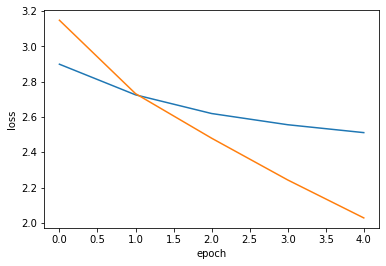

In [95]:
embedding_size = 256
hidden_size = 1024
train_model_and_visualization(embedding_size, hidden_size, 5)

Epoch 1/5
3835/3835 [==============================] - 651s 169ms/step - loss: 3.3683 - accuracy: 0.5147 - val_loss: 2.8760 - val_accuracy: 0.5442
Epoch 2/5
3835/3835 [==============================] - 633s 165ms/step - loss: 2.7369 - accuracy: 0.5512 - val_loss: 2.6998 - val_accuracy: 0.5616
Epoch 3/5
3835/3835 [==============================] - 632s 165ms/step - loss: 2.4510 - accuracy: 0.5723 - val_loss: 2.5937 - val_accuracy: 0.5766
Epoch 4/5
3835/3835 [==============================] - 632s 165ms/step - loss: 2.1947 - accuracy: 0.5964 - val_loss: 2.5267 - val_accuracy: 0.5921
Epoch 5/5
3835/3835 [==============================] - 630s 164ms/step - loss: 1.9731 - accuracy: 0.6235 - val_loss: 2.4978 - val_accuracy: 0.6059
Model: "text_generator_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      multiple                  20481024  
_________________________________________

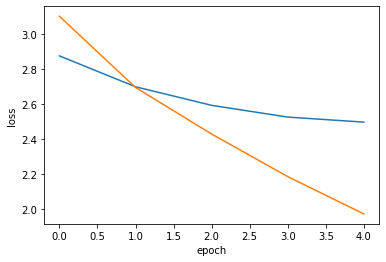

In [97]:
embedding_size = 1024
hidden_size = 1024
train_model_and_visualization(embedding_size, hidden_size, 5)

Epoch 1/5
3835/3835 [==============================] - 429s 111ms/step - loss: 3.7246 - accuracy: 0.4935 - val_loss: 3.0424 - val_accuracy: 0.5346
Epoch 2/5
3835/3835 [==============================] - 425s 111ms/step - loss: 2.9406 - accuracy: 0.5387 - val_loss: 2.8363 - val_accuracy: 0.5491
Epoch 3/5
3835/3835 [==============================] - 443s 115ms/step - loss: 2.6978 - accuracy: 0.5547 - val_loss: 2.7271 - val_accuracy: 0.5588
Epoch 4/5
3835/3835 [==============================] - 445s 116ms/step - loss: 2.5025 - accuracy: 0.5691 - val_loss: 2.6680 - val_accuracy: 0.5670
Epoch 5/5
3835/3835 [==============================] - 444s 116ms/step - loss: 2.3538 - accuracy: 0.5806 - val_loss: 2.6381 - val_accuracy: 0.5758
Model: "text_generator_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      multiple                  20481024  
_________________________________________

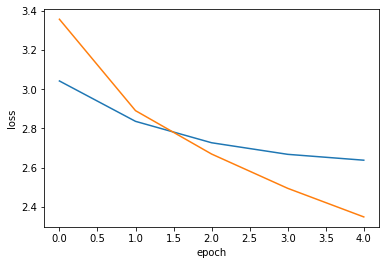

In [98]:
embedding_size = 1024
hidden_size = 256
train_model_and_visualization(embedding_size, hidden_size, 5)

Epoch 1/5
3835/3835 [==============================] - 1289s 331ms/step - loss: 3.2694 - accuracy: 0.5209 - val_loss: 2.6848 - val_accuracy: 0.5636
Epoch 2/5
3835/3835 [==============================] - 1262s 329ms/step - loss: 2.4472 - accuracy: 0.5790 - val_loss: 2.4326 - val_accuracy: 0.5962
Epoch 3/5
3835/3835 [==============================] - 1261s 329ms/step - loss: 1.9523 - accuracy: 0.6341 - val_loss: 2.2981 - val_accuracy: 0.6257
Epoch 4/5
3835/3835 [==============================] - 1248s 325ms/step - loss: 1.5765 - accuracy: 0.6918 - val_loss: 2.2562 - val_accuracy: 0.6472
Epoch 5/5
3835/3835 [==============================] - 1262s 329ms/step - loss: 1.3176 - accuracy: 0.7405 - val_loss: 2.2639 - val_accuracy: 0.6604
Model: "text_generator_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      multiple                  20481024  
____________________________________

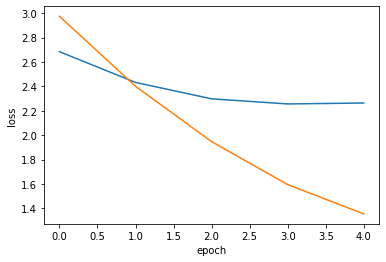

In [99]:
embedding_size = 1024
hidden_size = 2048
train_model_and_visualization(embedding_size, hidden_size, 5)

Epoch 1/5
3835/3835 [==============================] - 916s 238ms/step - loss: 3.3540 - accuracy: 0.5161 - val_loss: 2.8662 - val_accuracy: 0.5460
Epoch 2/5
3835/3835 [==============================] - 910s 237ms/step - loss: 2.7221 - accuracy: 0.5521 - val_loss: 2.6985 - val_accuracy: 0.5612
Epoch 3/5
3835/3835 [==============================] - 909s 237ms/step - loss: 2.4475 - accuracy: 0.5722 - val_loss: 2.5953 - val_accuracy: 0.5766
Epoch 4/5
3835/3835 [==============================] - 910s 237ms/step - loss: 2.2004 - accuracy: 0.5953 - val_loss: 2.5374 - val_accuracy: 0.5906
Epoch 5/5
3835/3835 [==============================] - 896s 234ms/step - loss: 1.9719 - accuracy: 0.6229 - val_loss: 2.5132 - val_accuracy: 0.6046
Model: "text_generator_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      multiple                  40962048  
_________________________________________

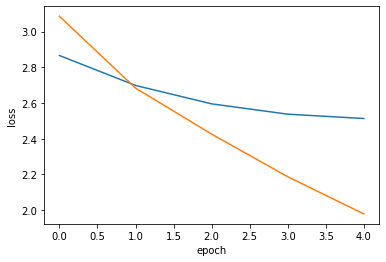

In [100]:
embedding_size = 2048
hidden_size = 1024
train_model_and_visualization(embedding_size, hidden_size, 5)

loss 와 accuracy 결과가 좋았던 하이퍼파라미터로 이번엔 epochs 10으로 돌려보았다.

Epoch 1/10
3835/3835 [==============================] - 1281s 329ms/step - loss: 3.2434 - accuracy: 0.5230 - val_loss: 2.6704 - val_accuracy: 0.5656
Epoch 2/10
3835/3835 [==============================] - 1237s 323ms/step - loss: 2.4248 - accuracy: 0.5817 - val_loss: 2.4068 - val_accuracy: 0.5995
Epoch 3/10
3835/3835 [==============================] - 1239s 323ms/step - loss: 1.9138 - accuracy: 0.6401 - val_loss: 2.2715 - val_accuracy: 0.6296
Epoch 4/10
3835/3835 [==============================] - 1238s 323ms/step - loss: 1.5336 - accuracy: 0.7002 - val_loss: 2.2253 - val_accuracy: 0.6508
Epoch 5/10
3835/3835 [==============================] - 1237s 323ms/step - loss: 1.2913 - accuracy: 0.7462 - val_loss: 2.2451 - val_accuracy: 0.6626
Epoch 6/10
3835/3835 [==============================] - 1237s 322ms/step - loss: 1.1508 - accuracy: 0.7760 - val_loss: 2.2885 - val_accuracy: 0.6686
Epoch 7/10
3835/3835 [==============================] - 1238s 323ms/step - loss: 1.0720 - accuracy: 0.7935

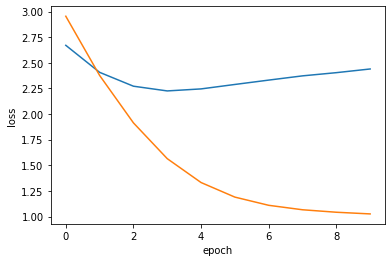

In [102]:
embedding_size = 1024
hidden_size = 2048
train_model_and_visualization(embedding_size, hidden_size)

# 모델 수정하기

![image](https://user-images.githubusercontent.com/63278762/127500610-3d1b5310-3962-4319-a122-58f598e4eb72.png)


embedding_size = 1024, hidden_size = 2048    
하이퍼파라미터를 줬을 때 loss에 대한 결과를 시각화해보았다. 그 결과 epoch가 3정도에서 val_loss가 올라가는 것을 볼 수 있었고, 오버피팅이 나는 것을 알 수 있었다. 때문에 모델에 dropout 레이어를 추가해서 모델을 수정 후 다시 훈련시켜보았다.

In [103]:
class TextGenerator_New(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(.2)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.dropout(out)
        out = self.linear(out)
        
        return out

In [105]:
embedding_size = 1024
hidden_size = 2048
model = TextGenerator_New(tokenizer.num_words+1, embedding_size, hidden_size)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction='none'
)
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)
tf.test.is_gpu_available()
model.summary()

Epoch 1/10
3835/3835 [==============================] - 1248s 320ms/step - loss: 3.2453 - accuracy: 0.5236 - val_loss: 2.7138 - val_accuracy: 0.5617
Epoch 2/10
3835/3835 [==============================] - 1236s 322ms/step - loss: 2.5343 - accuracy: 0.5734 - val_loss: 2.4683 - val_accuracy: 0.5917
Epoch 3/10
3835/3835 [==============================] - 1235s 322ms/step - loss: 2.0823 - accuracy: 0.6189 - val_loss: 2.3193 - val_accuracy: 0.6183
Epoch 4/10
3835/3835 [==============================] - 1235s 322ms/step - loss: 1.7261 - accuracy: 0.6671 - val_loss: 2.2449 - val_accuracy: 0.6411
Epoch 5/10
3835/3835 [==============================] - 1236s 322ms/step - loss: 1.4754 - accuracy: 0.7090 - val_loss: 2.2261 - val_accuracy: 0.6566
Epoch 6/10
3835/3835 [==============================] - 1235s 322ms/step - loss: 1.3130 - accuracy: 0.7395 - val_loss: 2.2474 - val_accuracy: 0.6660
Epoch 7/10
3835/3835 [==============================] - 1234s 322ms/step - loss: 1.2079 - accuracy: 0.7618

### 체크포인트 구성해서 시도해보기

In [110]:
checkpoint_dir = './training_Lyricist/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix,
    save_weights_only=True
)

In [112]:

embedding_size = 1024
hidden_size = 2048
model = TextGenerator_New(tokenizer.num_words+1, embedding_size, hidden_size)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction='none'
)
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=256, callbacks=[checkpoint_callback])
tf.test.is_gpu_available()
model.summary()

Epoch 1/10
480/480 [==============================] - 612s 1s/step - loss: 3.8332 - accuracy: 0.4825 - val_loss: 2.9546 - val_accuracy: 0.5379
Epoch 2/10
480/480 [==============================] - 600s 1s/step - loss: 2.8391 - accuracy: 0.5439 - val_loss: 2.7191 - val_accuracy: 0.5572
Epoch 3/10
480/480 [==============================] - 601s 1s/step - loss: 2.5240 - accuracy: 0.5669 - val_loss: 2.5333 - val_accuracy: 0.5784
Epoch 4/10
480/480 [==============================] - 603s 1s/step - loss: 2.2104 - accuracy: 0.5980 - val_loss: 2.3871 - val_accuracy: 0.6008
Epoch 5/10
480/480 [==============================] - 605s 1s/step - loss: 1.9204 - accuracy: 0.6358 - val_loss: 2.2826 - val_accuracy: 0.6216
Epoch 6/10
480/480 [==============================] - 601s 1s/step - loss: 1.6697 - accuracy: 0.6762 - val_loss: 2.2062 - val_accuracy: 0.6404
Epoch 7/10
480/480 [==============================] - 602s 1s/step - loss: 1.4655 - accuracy: 0.7132 - val_loss: 2.1631 - val_accuracy: 0.6554

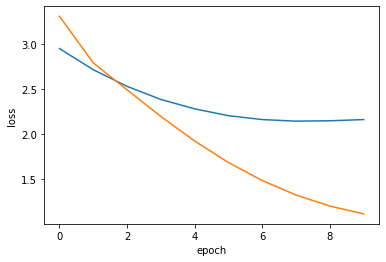

In [115]:
fig, loss_ax = plt.subplots()
loss_ax.plot(history.history['val_loss'], label='var_loss')    
loss_ax.plot(history.history['loss'], label='loss')  
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
plt.show()

# 모델 평가하기

In [113]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor=tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token=tokenizer.word_index["<end>"]
    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [114]:
input_token = ['love', 'you', 'time', 'enough', 'like']
for _ in input_token:
    print(generate_text(model, tokenizer, init_sentence=f"<start> {_}"))

<start> love is a notion that i can't forget <end> 
<start> you know what i'm talkin' about <end> 
<start> time to think it through <end> 
<start> enough to cop a six buy the house on the beach uhhuh <end> 
<start> like a comet <end> 


# 회고

## 1) 배운 점
- 이번 노드를 통해서 자연어처리를 어떤 식으로 진행하는지 맛보기로 배운 것 같다.
- train 데이터의 loss와 test 데이터의 val_loss의 관계로 오버피팅인디 언더피팅인지 파악하는 법을 배웠다.
- 문장 전처리할 때 regex(Regular Expression)을 사용하는 법을 알게되었다.
- model.fit의 파라미터로 어떤 옵션들이 들어가는지 알게 되었다.

## 2) 아쉬운 점 및 궁금한 점
- 모델 훈련에 시간이 오래걸려 좀 더 도전적으로 수정하면서 테스트해보지 못했다.
- dataset을 쓰면 성능이 더 좋아진다고 튜토리얼 페이지에서는 나와있어서 시도해봤지만 validation_data에 넣을 수 없어서 기존에 썼던 train_test_split를 사용했다. dataset을 쓰면서 validation_data에 넣을 수 있는 방법이 있는지 궁금하고, dataset과 train_test_split의 성능 차이가 궁금하다.
- 결국 validation loss를 2.2이하로 만들지 못했다. 이유가 무엇일까??
- ModelCheckpoint라는 것을 뒤늦게 알았다!!! 이것도 적용해서 테스트하고 싶고, 뭔지도 자세히 공부해봐야겠다.

# Reference

* https://ichi.pro/ko/keras-ui-validation-splitgwa-sklearnui-train-test-split-chaijeom-haegyeol-11268786468659
* https://keras.io/api/models/model_training_apis/#fit-method
* https://vitalflux.com/overfitting-underfitting-concepts-interview-questions/
* https://www.tensorflow.org/tutorials/text/text_classification_rnn#%EB%AA%A8%EB%8D%B8_%EB%A7%8C%EB%93%A4%EA%B8%B0